# Classification of Handwritten Digits

Michael P. Friedlander  
Yifan Sun  
Invalid Date

In [1]:
using Images, Plots, Statistics, LinearAlgebra, MAT, Printf

$$
\def\argmin{\operatorname*{argmin}}
\def\Ball{\mathbf{B}}
\def\bmat#1{\begin{bmatrix}#1\end{bmatrix}}
\def\Diag{\mathbf{Diag}}
\def\half{\tfrac12}
\def\ip#1{\langle #1 \rangle}
\def\maxim{\mathop{\hbox{\rm maximize}}}
\def\maximize#1{\displaystyle\maxim_{#1}}
\def\minim{\mathop{\hbox{\rm minimize}}}
\def\minimize#1{\displaystyle\minim_{#1}}
\def\norm#1{\|#1\|}
\def\Null{{\mathbf{null}}}
\def\proj{\mathbf{proj}}
\def\R{\mathbb R}
\def\Re{\mathbb R}
\def\Rn{\R^n}
\def\rank{\mathbf{rank}}
\def\range{{\mathbf{range}}}
\def\span{{\mathbf{span}}}
\def\st{\hbox{\rm subject to}}
\def\T{^\intercal}
\def\textt#1{\quad\text{#1}\quad}
\def\trace{\mathbf{trace}}
$$

In this assignment you will implement two binary classification models
to disambiguate images of handwritten digits “4” and “9”. We’ll use two
different classification models: linear regression and logistic
regression and compare their performance. There are more general
approaches to this problem. Our emphasis here, however, is to use basic
tools of optimization.

## 1 MNIST dataset

[Download](../assets/mnist.mat) an abbreviated version of the MNIST
dataset.

In [2]:
vars = matread("../assets/mnist.mat") # adjust the file path if necessary
testX = vars["testX"]
testY = dropdims(Int.(vars["testY"]), dims=1)   # labels
trainX = vars["trainX"]
trainY = dropdims(Int.(vars["trainY"]), dims=1) # labels
varinfo(Regex(".*X|.*Y"))

Let’s find a few of the numbers 4 and 9 in the dataset.

Here are a few sample images that we’ll be using to train the
classifier.


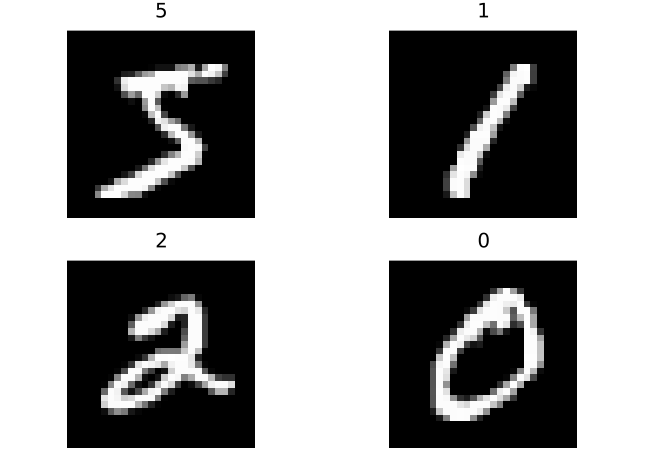

In [3]:
show_digit(X, i) = reinterpret(N0f8, reshape(X[i, :], 28, 28)') .|> Gray
p = map([1, 4, 6, 2]) do i
        plot(show_digit(trainX, i), title="$(trainY[i])",
             axis=nothing, showaxis=false, grid=false)
    end
plot(p..., layout=(2, 2))


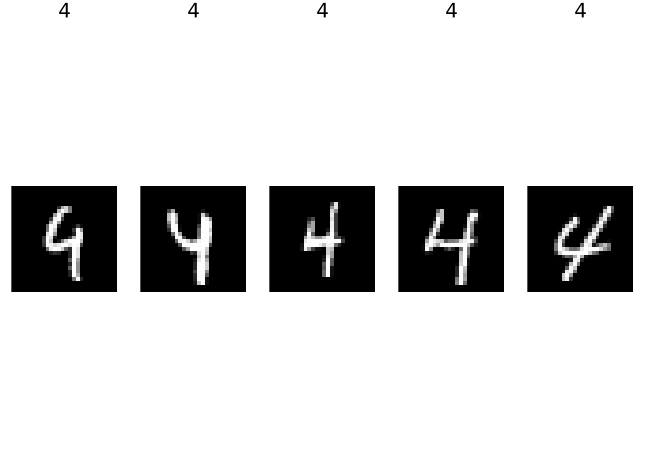

In [4]:
fours = trainX[trainY .== 4, :]
nines = trainX[trainY .== 9, :]
# select `k` random 4s and 9s
k = 5
p = map(1:k) do i
    plot(show_digit(fours, rand(1:size(fours, 1))), title="4",
         axis=nothing, showaxis=false, grid=false)
end
plot(p..., layout=(1, k))

### 1.1 Preprocessing

We need a matrix $A\in \Re^{m\times n}$ where $m$ is the number of
training samples (i.e., the number of 4s and 9s in the training set),
and $n = 28^2$ is the feature length. As in many data science projects,
the first step is in processing the data in order to find these
constants.

#### 1.1.1 Filter

First, filter out all datapoints in the test and train sets that are not
4s or 9s. Here we also convert the data into double precision floats.
(In practice we could save significant memory by using single precision,
but for simplicity we will use double precision for this assignment.)

In [5]:
"""
Filter out all except 4 and 9 digits.
Return values as floats
"""
function filter_49(X, Y)
    idx = (Y .== 4) .| (Y .== 9)
    return Float64.(X[idx, :]), Float64.(Y[idx])
end

Atrain, btrain = filter_49(trainX, trainY)
Atest, btest = filter_49(testX, testY);

#### 1.1.2 Relabel

Redefine the vector of labels in `b` and `btest` into vectors with
$\pm 1$ values so that

$$
b_i = \begin{cases}
  +1 & \text{if sample $i$ is a 4}, \\
  -1 & \text{if sample $i$ is a 9}.
\end{cases}
$$

In [6]:
is49(y) = 1.0 * (y .== 4) - 1.0 * (y .== 9)
btrain = is49.(btrain)
btest = is49.(btest);

#### 1.1.3 Center and normalize

Two tricks that often help in machine learning is to remove any bias
(i.e., the mean) and normalize the data to have unit variance. Note that
we take care not to divide by zero in the variance normalization step.

Why do we need to remove the mean *before* normalizing the variance?

In [7]:
function debias_and_normalize!(A, μ, σ)
    A .-= μ
    A ./= max.(σ, 1)
end
μtrain = mean(Atrain, dims=1)
σtrain = std(Atrain, dims=1)
debias_and_normalize!(Atrain, μtrain, σtrain);

## 2 Linear regression

Linear regression models are an easy “first pass” at a classification
problem because they are easy to implement and understand. There are
many reasons, however, why they may not be the best choice. In this set
of questions you’ll implement the least-squares classifier and evaluate
its performance.

We now have our training matrix `A` and training labels `b`. We will use
these to train a linear regression model

$$
x_{ls} = \mathop{\rm argmin}_x \|Ax - b\|_2^2.
$$

### 2.1 Train the least-squares model

Solve this problem and report the value of the objective value at the
least-squares solution.

### 2.2 Construct a classifier

Discuss how to construct a *classifier* from the least-squares solution
$x_{ls}$. The classifier is a function $C(x, y)$ that takes a model
vector $x\in\Re^n$ and a feature vector $y\in\Re^n$ (in this case, the
vectorized image) and evaluates a predicted label +1 or -1.

For the given data set of feature-label pairs
$\{a_i,b_i\}_{i=1}^m\subset\Rn\times\R$, the misclassification error
rate is

$$
 \text{\tt error\_rate} = \frac{1}{m}\sum_{i=1}^m \mathbb{1}\{C(x_{ls}, a_i) \neq b_i\},
$$

where $\mathbb{1}\{p\}$ is the indicator function that evaluates to 1 if
$p$ is true and 0 otherwise and $(a_i, b_i)$ are the $i$th row of $A$
(the $i$th feature vector) and the $i$th label.

``` julia
function C(x, a)
    # fill in
end
function error_rate(A, b, x)
    # fill in
end
```

### 2.3 Evaluate the training misclassification rate

Now evaluate the misclassification rate on the training set.

In [10]:
train_error_rate = error_rate(Atrain, btrain, xls)
@printf("The misclassification rate on the training set is %.2f%%", train_error_rate * 100)

The misclassification rate on the training set is 3.08%

### 2.4 Evaluate the testing misclassification rate

Both the loss and training error are good ways of evaluating how well we
did in both fitting the model and solving the optimization problem.
However, it can only tell us about data we already observed. We don’t
know what will happen with data we haven’t yet seen. To do this, we need
to evaluate the *testing error*.

Before using the testing data, however, we must first preprocess it in
*exactly* the same way we preprocessed the training data. That means
using the *same* vector for both the mean and the standard deviation,
computed from the *trainig data alone*.

Discuss briefly why you think it may be important to not recompute these
constants.

## 3 Logistic regression

Now, rather than fitting data linearly to the +1 and -1 labels, we’ll
now use logistic regression to fit of the *likelihood* of being 0 or 1.
In particular, for a feature vector $a\in\Re^n$ and label $b\in\{0,1\}$,
we define the probability that the label $b$ is associated with the
feature vector $a$ by evaluating the function

$$
\Pr(b\mid a, x) = 
\begin{cases}
    \sigma(x'a) & \text{if } b = 1, \\
    1 - \sigma(x'a) & \text{if } b = 0,
\end{cases}
$$

where $\sigma(z) = 1/(1 + \exp(-z))$ is the *sigmoid* function.

In [12]:
σ(z) = 1 / (1 + exp(-z))
plot(σ, -5, 5, xlabel="z", ylabel="σ(z)", label=false, size=(200, 200))

This function can be interpreted as a “soft switch”: the input $z$ can
be viewed as a “confidence” that the label is 1, and the output
$\sigma(z)$ is the probability that the label is 1.

### 3.1 Likelihood and log-likelihood

Now assume that our training data $\{a_1, \ldots, a_m\}$ and labels
$\{b_1, \ldots, b_m\}$ are i.i.d. Then the likelihood of oberving this
entire training set, given our model $x$, is

$$
\text{Likelihood}(x) = \prod_{i=1}^m \Pr(b_i\mid a_i, x)
= \prod_{i=1}^m \sigma(x^T a_i)^{b_i} (1 - \sigma(x^T a_i))^{1 - b_i}.
$$

We instead **minimize** the negative log-likelihood function (i.e.,
**maximize** the log-likelihood function):

$$
f(x) = -\log(\text{Likelihood}(x)),
$$

which is the sum of the negative log-likelihoods of each individual data
point. This is a standard trick in statistics, and is equivalent to
**maximizing** the likelihood itself.

1.  Explain why it’s equivalent to maximize the log-likelihood instead
    of the likelihood.

<!-- -->

1.  Derive the gradient and Hessian of the log-likelihood function
    $f(x)$.

### 3.2 Train the logistic regression model

In this exercise you’ll train the logistic regression model using
steepest descent.

First, you’ll need to convert the labels to 0 or 1. You can do this by
adding 1 to the labels and dividing by 2.

In [13]:
# Convert labels to 0 or 1, overwriting the old labels
btrain01 = (btrain .+ 1) ./ 2
btest01 = (btest .+ 1) ./ 2;

Write the loss function and its gradient.
<span class="column-margin margin-aside">If you worry that
$\log(\sigma(a_i^T x)) = -\infty$ or $\log(1-\sigma(a_i^Tx))=-\infty$
because the sigmoid function evaluates close to 0 or 1, you may replace
$\sigma(a_i^Tx)$ with $\max(\min(\sigma(a_i^T x)),\epsilon),\epsilon)$
where $\epsilon$ is some small number.</span>

``` julia
"""
Loss function. Note that we use `min` and `max` to avoid taking the log of zero or one.
"""
function f(x)
   z = σ.(Atrain*x)
   zadj = min.(max.(z, eps()), 1-eps())
   return sum(-btrain01 .* log.(zadj) - (1.0 .- btrain01) .* log.(1.0 .- zadj))
end
"Loss gradient"
∇f(x) = # ... fill in
```

#### 3.2.1 Steepest descent with constant stepsize

Train the model using steepest descent with

-   a constant stepsize of $\bar\alpha = 1/m$
-   an initial value $x^{(0)} = 0$
-   for at most 1000 iterations or until the gradient is less than
    $10^{-6}$

As you train the model, keep track of the training and testing error
rates and the loss at each iteration.

> **Tip**
>
> You can use the following struct to keep track of the training and
> testing error rates and the loss at each iteration.
>
> ``` julia
> "Trace for train and test error rates, and loss"
> struct ErrorRateTrace
>     train::Vector{Float64}
>     test::Vector{Float64}
>     loss::Vector{Float64}
> end
> "Trace constructor"
> ErrorRateTrace() = ErrorRateTrace([], [], [])
> "Update trace with new values"
> function update!(t::ErrorRateTrace, x)
>     push!(t.train, error_rate(Atrain, btrain, x)),
>     push!(t.test, error_rate(Atest, btest, x))
>     push!(t.loss, f(x))
> end;
> ```


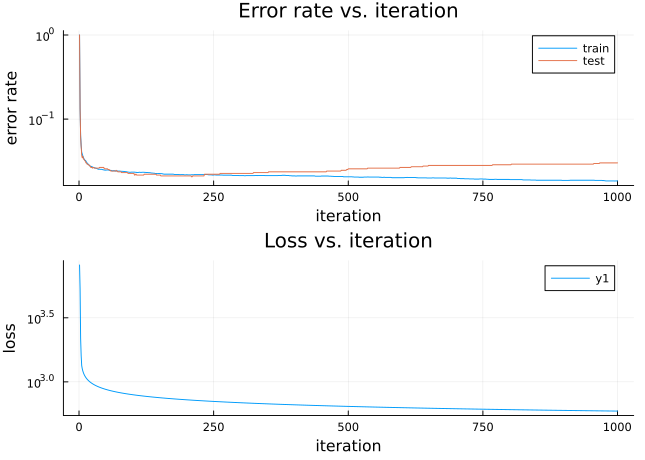

In [18]:
p_err = plot(yscale=:log10, xlab="iteration", ylab="error rate", title="Error rate vs. iteration")
plot!(p_err, trace.train, label="train")
plot!(p_err, trace.test, label="test")

p_loss = plot(trace.loss, yscale=:log10, xlabel="iteration", ylabel="loss", title="Loss vs. iteration")
plot(p_err, p_loss, layout=(2, 1))

### 3.3 Steepest descent with backtracking line search

Repeat the experiments above using steepest descent with backtracking
line search.

### 3.4 Visualize the misfits

Pick three images that fit the least-squares model well and three that
do not. Do the same for the logistic model. Display these images and
discuss why you think the model may have had trouble with the misfitting
images.